This dataset includes the locations of businesses that pay taxes to the City and County of San Francisco. Each registered business may have multiple locations and each location is a single row. The Treasurer & Tax Collector’s Office collects this data through business registration applications, account update/closure forms, and taxpayer filings.


In [9]:
## Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas.tools import sjoin
import folium
from folium.plugins import MarkerCluster
import shapely
import zipcode
%matplotlib notebook

In [10]:
## Read dataset
data = pd.read_csv('sfbusinessdataset.csv',encoding = "ISO-8859-1")
data.columns.values

array(['Location Id', 'Business Account Number', 'Ownership Name',
       'DBA Name', 'Street Address', 'City', 'State', 'Source Zipcode',
       'Business Start Date', 'Business End Date', 'Location Start Date',
       'Location End Date', 'Mail Address', 'Mail City', 'Mail Zipcode',
       'Mail State', 'NAICS Code', 'NAICS Code Description',
       'Parking Tax', 'Transient Occupancy Tax', 'LIC Code',
       'LIC Code Description', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Business Corridor',
       'Business Location'], dtype=object)

In [11]:
data.head()

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,...,NAICS Code,NAICS Code Description,Parking Tax,Transient Occupancy Tax,LIC Code,LIC Code Description,Supervisor District,Neighborhoods - Analysis Boundaries,Business Corridor,Business Location
0,0026883-11-001,26883,Chevron Texaco Corp,Chevron,2998 San Jose Av,San Francisco,CA,94112.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,11.0,Oceanview/Merced/Ingleside,NaN,"2998 SAN JOSE AV\rSan Francisco, CA 94112\r(37..."
1,0026883-12-001,26883,Chevron Texaco Corp,Chevron,301 Claremont Blvd,San Francisco,CA,94127.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,7.0,West of Twin Peaks,NaN,"301 CLAREMONT BLVD\rSan Francisco, CA 94127\r(..."
2,0026883-13-001,26883,Chevron Texaco Corp,Chevron,3675 Geary Blvd,San Francisco,CA,94118.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,1.0,Lone Mountain/USF,NaN,"3675 GEARY BLVD\rSan Francisco, CA 94118\r(37...."
3,0026883-15-001,26883,Chevron Texaco Corp,Chevron,2301 Lombard St,San Francisco,CA,94123.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,2.0,Marina,NaN,"2301 LOMBARD ST\rSan Francisco, CA 94123\r(37...."
4,0026883-16-001,26883,Chevron Texaco Corp,Chevron,1288 19th St,San Francisco,CA,94107.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,10.0,Potrero Hill,NaN,"1288 19TH ST\rSan Francisco, CA 94107\r(37.761..."


Since we are only looking at businesses in SF city and county, filter only for 'CA'

In [12]:
data = data[data['State'] == 'CA']

In [13]:
data['City'].value_counts()[0:8]

San Francisco    154082
San+francisco     14398
Oakland            4072
Daly+city          2605
San+jose           1741
Hayward            1233
Richmond           1184
Sacramento         1061
Name: City, dtype: int64

Cities apart from SF are a part of the SF county  
Assuming them to be a part of analysis

## Q1) Which pockets in San Francisco have higher concentrations of active businesses?

In [14]:
data['Business End Date'].isnull().value_counts()

True     168802
False     42951
Name: Business End Date, dtype: int64

All business with no end dates are still active

In [15]:
mask = data['Business End Date'].isnull()
activebus = data[mask]

Since each business has multiple entries due to different locations. The business could have closed in one location and reopened in another.  
Filter out all location end dates with no null values

In [16]:
activebus['Location End Date'].isnull().value_counts()

True     152735
False     16067
Name: Location End Date, dtype: int64

In [17]:
mask = activebus['Location End Date'].isnull()
activebus = activebus[mask]

In [18]:
activebus['Business Location'].notnull().value_counts()

True     117665
False     35070
Name: Business Location, dtype: int64

In [19]:
activebus['Source Zipcode'].notnull().value_counts()

True     152712
False        23
Name: Source Zipcode, dtype: int64

#### Get latitude and longitude from Business Location

In [20]:
## split on basis of '\r' seperator
activebus['Business Location'] = activebus['Business Location'].astype(str)
split_loc = activebus['Business Location'].map(lambda x: x.split('\r'))
def create_latlong(x):
    if len(x) == 3:
        ### return lat-long for all strings with full address
        return x[2]
    else:
        ### else return None
        return None

latlong = split_loc.apply(create_latlong)    
activebus['latlong'] = latlong

In [21]:
## Replace empty cells with NA
activebus['latlong'].replace(r'\s+',np.nan,inplace = True,regex = True)

#### For missing values get lat-long from zipcode

In [22]:
source_zipcode = activebus[activebus['Source Zipcode'].notnull()]['Source Zipcode'].astype(int).astype(str)

In [23]:
def zip_lat(x):
    if zipcode.isequal(x) == None:
        ### incase of empty cells or invalid zipcodes
        return None
    else:
        return (zipcode.isequal(x).lat,zipcode.isequal(x).lon)

latlong_zip= source_zipcode.apply(zip_lat)
activebus['latlong_zip'] = latlong_zip

In [24]:
### Fill with lat long values obtained from zipcode where value is missing for latitude, longitude
activebus['latlong'].fillna(activebus['latlong_zip'],inplace = True)

In [25]:
activebus['latlong'].isnull().value_counts()

False    152520
True        215
Name: latlong, dtype: int64

In [26]:
(215/152520)*100

0.14096511932861266

In [27]:
### 0.14% values missing which can be safely ignored

In [28]:
### Plot map using zipcode to understand which pockets have most active businesses
df = pd.DataFrame(activebus['latlong'].dropna().value_counts().reset_index())
df.rename(columns = {'index':'lat_long','latlong':'count'},inplace = True,index=str)
df['count'].replace(2220,np.nan,inplace = True,regex = True)
df.dropna(subset = ['count'],inplace = True)

In [29]:
### Store lat, long and active business counts in a seperate dataframe
lat = df['lat_long'].map(lambda x: x[0])
lon = df['lat_long'].map(lambda x: x[1])
active_business = df['count']
df = pd.DataFrame({'lat':lat,'lon':lon, 'business_counts':active_business})

In [30]:
def plot_map(df):
    # generate a new map
    folium_map = folium.Map(location=[37.77, -122.41],
                            zoom_start=10,
                            tiles="CartoDB dark_matter",
                            width='50%')

    # for each row in the data, add a cicle marker
    for index, row in df.iterrows():      
        # generate the popup message that is shown on click.
        popup_text = "Active business counts: {}<br>"
        popup_text = popup_text.format(row['business_counts'])      
        # radius of circles
        radius = row['business_counts']/800
        
        # add marker to the map
        folium.CircleMarker(location=(row["lat"],
                                      row["lon"]),
                            color='#0A8A9F',
                            popup=popup_text,
                            radius = radius,
                            fill=True).add_to(folium_map)
    return folium_map

In [31]:
plot_map(df)

#### The size of the circle in this map denotes number of active businesses. The map can be zoomed in to see which areas have most active businesses

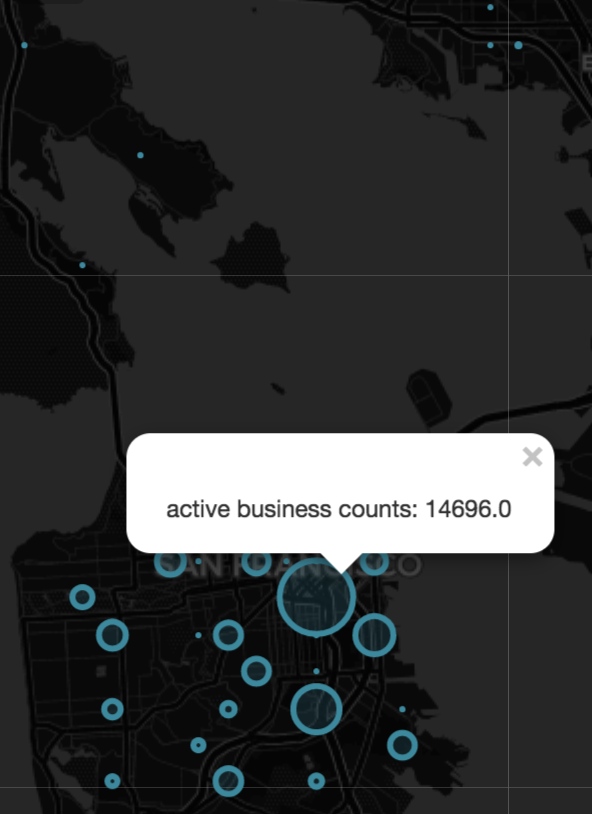

In [32]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "image1.png", width=400, height=300)

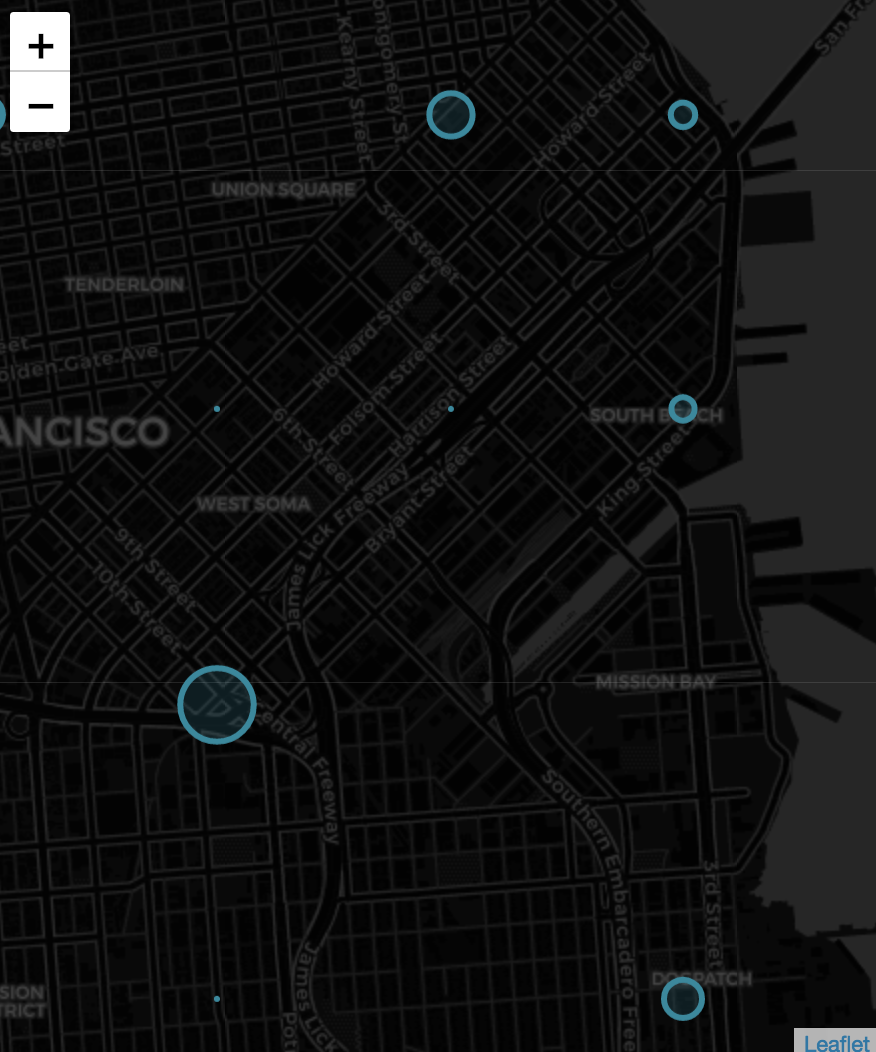

In [33]:
Image(filename = "image2.png", width=400, height=300)

Most active businesses are 14696 in San Francisco area around Central Freeway.  
Most of the active businesses are also located around Union Square, China Market and South beach as these are the commercial hub of the city and hence more reachability to customers, and availibility of huge market

### Q2)
#### To promote growth of certain industry types which are less popular in San Francisco, the county is offering a tax break for new businesses falling under these categories to encourage them to set up shop in San Francisco. Identify the NAICS code and description of businesses that would benefit from this scheme.

In [34]:
### see which industry types are less popular
### check for new businesses in this category

In [35]:
activebus['NAICS Code'].notnull().value_counts()

True     104241
False     48494
Name: NAICS Code, dtype: int64

In [36]:
48494/104241

0.4652104258401205

In [37]:
### Since NAICS Code is user generated, these entries cannot be imputed using data from other entries
## removing these entries from data

In [38]:
data1 = activebus[activebus['NAICS Code'].notnull()]

In [39]:
df = pd.DataFrame(data1['NAICS Code'].value_counts().reset_index())
df

,index,NAICS Code
0,4800-4999,20662
1,5300-5399,17177
2,5400-5499,14535
3,2300-2399,9944
4,4400-4599,8145
5,7220-7229,6674
6,6100-6299,4912
7,7100-7199,4676
8,7210-7219,3317
9,4200-4299,2654


In [40]:
### Looking at NAICS code counts below 25th percentile
import numpy as np
a = df['NAICS Code']
p = np.percentile(a, 25)
p

1671.0

In [41]:
### Focussing on business with counts less than 1671
df = df[df['NAICS Code'] <= 1671]
df

,index,NAICS Code
14,3100-3399,1335
15,8100-8399,568
16,5240-5249,452
17,2200-2299,181
18,8110-8139,9


In [42]:
### Filtering dataset on above NAICS code to get new business in the area

In [43]:
unrecbus = data1[data1['NAICS Code'].isin(df['index'])]

#### For every business need to check how many dates exist
#### some businesses might be old but might have a new location opened up

In [44]:
unrec1 = pd.DataFrame(unrecbus['Business Account Number'].value_counts().reset_index()).rename(columns = {'Business Account Number': 'count',
                                                                                                'index':'Business Account Number'})
unrec1.head()

,Business Account Number,count
0,364434,20
1,394051,12
2,50345,12
3,454332,10
4,451897,9


In [45]:
### get minimum date and max date for each business to see if all the locations sprung up in latest years

In [46]:
maxdate = pd.DataFrame(unrecbus.groupby(['Business Account Number'])['Business Start Date'].max().reset_index())
mindate = pd.DataFrame(unrecbus.groupby(['Business Account Number'])['Business Start Date'].min().reset_index())
merged = pd.merge(maxdate,mindate, on=['Business Account Number']).rename(columns = {'Business Start Date_x':'maxdate','Business Start Date_y':'mindate'})
merged = pd.merge(merged,unrec1,on = ['Business Account Number'])[['Business Account Number', 'maxdate','mindate','count']]
merged.head()
### join 3 tables and get max and min years and number of entries for each business

,Business Account Number,maxdate,mindate,count
0,780,10/1/1968,10/1/1968,3
1,1072,10/1/1968,10/1/1968,1
2,1341,10/1/1968,10/1/1968,3
3,1495,10/1/1968,10/1/1968,1
4,1775,10/1/1968,10/1/1968,1


In [47]:
### get all index for minimum start date in last 5 years
merged['min_year'] = merged['maxdate'].apply(lambda x: x[-4:])
merged['max_year'] = merged['mindate'].apply(lambda x: x[-4:])
merged = merged[['Business Account Number','min_year','max_year','count']]

In [48]:
merged[merged['min_year'] >= '2011']['count'].value_counts()

1    1092
2      74
3      12
4       4
Name: count, dtype: int64

In [49]:
### Most of the business in past 5 years have opened up in only 1 location

In [50]:
newbus = unrecbus['Business Start Date'].apply(lambda x: x[-4:]).value_counts()

In [51]:
#### get NAICS code and descriptions of all these businesses
merged = merged[merged['min_year'] >= '2011']
unrecbusnew = unrecbus[unrecbus['Business Account Number'].isin(merged['Business Account Number'])]

In [52]:
unrecbusnew.groupby(['NAICS Code','NAICS Code Description']).size().reset_index().rename(columns={0:'count'})

,NAICS Code,NAICS Code Description,count
0,2200-2299,Utilities,96
1,3100-3399,Manufacturing,626
2,5240-5249,Insurance,175
3,8100-8399,Certain Services,388
4,8110-8139,Certain Services,7


Utilities, Manufacturing, Insurance industries could benefit from the government tax scheme

### Q3)

### What are the different industry types that have come up in San Francisco over the years. Are there any trends you can identify ?

To obtain which industries have sprung up over the years:  
-- For each industry, get minimum business start date and maximum business start date to see when the first company in that industry registered and if that industry is still popular  
-- Getting counts for each industry can help understand the number of registered companies and how popular the industry is  


We can consider even the businesses that were closed in this case as we need to see popularity of industries and are concerned with them being existent at some point in time

In [53]:
### For every NAICS Code and corresponding description get max date, min date and business count for each NAICS
maxdate = pd.DataFrame(data.groupby(['NAICS Code','NAICS Code Description'])['Business Start Date'].max().reset_index())
mindate = pd.DataFrame(data.groupby(['NAICS Code','NAICS Code Description'])['Business Start Date'].min().reset_index())
merged = pd.merge(maxdate,mindate, on=['NAICS Code','NAICS Code Description']).rename(columns = {'Business Start Date_x': 'maxdate','Business Start Date_y':'mindate'})
unrec1 = pd.DataFrame(data['NAICS Code'].value_counts().reset_index()).rename(columns = {'NAICS Code':'count','index':'NAICS Code'})
merged = pd.merge(merged,unrec1,on = 'NAICS Code')[['NAICS Code', 'NAICS Code Description','maxdate','mindate','count']]
merged

,NAICS Code,NAICS Code Description,maxdate,mindate,count
0,2200-2299,Utilities,9/23/2001,1/1/1993,194
1,2300-2399,Construction,9/9/2016,1/1/1968,11521
2,3100-3399,Manufacturing,9/9/2015,1/1/1969,1607
3,4200-4299,Wholesale Trade,9/9/2015,1/1/1968,3115
4,4400-4599,Retail Trade,9/9/2016,1/1/1958,9959
5,4800-4999,Transportation and Warehousing,9/9/2016,1/1/1969,24744
6,5100-5199,Information,9/9/2016,09/01/1849,2862
7,5210-5239,Financial Services,9/9/2014,1/1/1970,3317
8,5240-5249,Insurance,9/9/2014,1/1/1965,566
9,5300-5399,Real Estate and Rental and Leasing Services,9/9/2016,1/1/1946,20287


All industry types except Utility has been existent till now no matter when they started.  
Also, 'certain services' although has been existent for about 65 years now, has only 895 companies as compared to some of the older services.

In [54]:
### Split each minimum date to years to understand how industries were introduced over years
merged['start_year'] = merged['mindate'].apply(lambda x: x[-4:])
merged.sort_values(['start_year'])[['start_year','NAICS Code Description','count']]

,start_year,NAICS Code Description,count
6,1849,Information,2862
11,1897,Administrative and Support Services,2820
9,1946,Real Estate and Rental and Leasing Services,20287
16,1947,Certain Services,817
13,1947,"Arts, Entertainment, and Recreation",5555
12,1948,Private Education and Health Services,5951
10,1957,"Professional, Scientific, and Technical Services",18154
4,1958,Retail Trade,9959
8,1965,Insurance,566
1,1968,Construction,11521


There is a shift in the industries which are being introduced over the years.  
The earlier industries focussed on personal development with arts, entertainment, private education, technical services being offered, i.e., being more user focussed and developing them as an individual.   

There has been a small shift towards industrial companies after 1960s with more focus on financial services, trading, manufacturing, transportation --> all factors associated with industrial aspects, developing economy

Also, 1960s saw most of the new industries coming up as it was the decade of development in the American History

## Q4)

### If you had more time, what other conclusions might you be able to draw from this data? What interesting stories might you be able to tell with the data? 

#### Adding more value for new businesses

Which places within San Francisco county are the most frequent choices for first time business setters?  
-- This can help understand what specific location level attributes attract businessmen and can help replicate  this across places. The benefits could be related to pricing, land availability, huge market size etc.   
This can be done by filtering data for when business started and plotted on map according to zip code

-- These locations also can be looked across various industries which is value adding for any new business looking to enter the market  
The above analysis can be broken down by NAICS Code to understand industries

-- Also, an analysis on the recent locations where businesses have sprung can help pinpoint the growth locations, this can be done by analyzing the location start date.

#### Adding more value for government

To understand parking taxes as there has been opposition around its increase in the recent times, which NAICS codes have most number of parking taxes --> this can be broken down into LIC codes to further understand what activities have most parking taxes

-- For businesses, this analysis can help understand their activities and associated parking tax  
-- For growth of new businesses, the government can do away with this tax initially  